# 02. Preprocessing & Feature Engineering

Generates features (MA, RSI, Lags) and prepares train/test splits.

## FIXES APPLIED:
1. **No data leakage**: All features shifted by 1 day
2. **New features**: Range, ATR, RSI, Volatility
3. **Fixed train/test split**: 2020-2024 train, 2025 test
4. **Proper feature scaling**: Target NOT scaled


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
from utils.data_manager import DataManager

%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (15, 7)


## 1. Load Raw Data

In [2]:
dm_raw = DataManager(data_type='raw', local_dir=os.path.join(root_path, 'data/raw'))
df = dm_raw.get_latest_data(force_refresh=False)

print(f"Loaded {len(df)} rows from {df.index.min().date()} to {df.index.max().date()}")

# DataManager already cleans columns, but let's ensure
if 'Volume' in df.columns:
    df = df.drop(columns=['Volume'])

# Ensure numeric columns
for col in ['Open', 'High', 'Low', 'Close']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=['Close'])
df = df[df['Close'] > 0]  # Remove zero/negative prices

print(f"After cleaning: {len(df)} rows")


Loaded 1308 rows from 2020-12-28 to 2026-01-07
After cleaning: 1308 rows


## 2. Feature Engineering

In [3]:
print("Creating features for tomorrow's prediction...")

# 1. TODAY'S Returns (available at market close)
df['Return'] = df['Close'].pct_change()

# 2. TODAY'S Technical Indicators (calculated from today's close)
for ma in [5, 10, 20, 50]:
    df[f'MA_{ma}'] = df['Close'].rolling(window=ma).mean()

# 3. TODAY'S RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = calculate_rsi(df['Close'], 14)

# 4. TODAY'S Range & Volatility
df['Range'] = df['High'] - df['Low']
df['Range_Pct'] = df['Range'] / df['Close']
df['True_Range'] = np.maximum(df['High'] - df['Low'], 
                             np.maximum(abs(df['High'] - df['Close'].shift(1)),
                                      abs(df['Low'] - df['Close'].shift(1))))
df['ATR_14'] = df['True_Range'].rolling(14).mean()

# 5. TODAY'S Volatility
df['Volatility_5d'] = df['Return'].rolling(5).std()
df['Volatility_20d'] = df['Return'].rolling(20).std()
df['Vol_Ratio'] = df['Volatility_5d'] / (df['Volatility_20d'] + 1e-10)

# 6. PAST Returns (Lagged - from history)
for r in [5, 20]:
    df[f'Return_{r}d'] = df['Close'].pct_change(periods=r)

for lag in [1, 2, 3, 5]:
    df[f'Lag_{lag}'] = df['Return'].shift(lag)  # Yesterday's return

# 7. TARGET: Tomorrow's return
df['Target'] = df['Return'].shift(-1)

print(f"\nFeatures created:")
print("  Today's features (no shift): Return, MA_*, RSI, Range, Volatility")
print("  Historical features (shifted): Lag_*, Return_*d")
print("  Target (shift -1): Tomorrow's return")

# Drop NaN and clean
initial_len = len(df)
df = df.dropna()
print(f"\nCleaned: {initial_len} → {len(df)} rows (removed NaN)")

# Save unscaled versions
df['Return_Unscaled'] = df['Return']
df['Close_Unscaled'] = df['Close']

print("✅ Feature engineering complete!")

Creating features for tomorrow's prediction...

Features created:
  Today's features (no shift): Return, MA_*, RSI, Range, Volatility
  Historical features (shifted): Lag_*, Return_*d
  Target (shift -1): Tomorrow's return

Cleaned: 1308 → 1258 rows (removed NaN)
✅ Feature engineering complete!


In [23]:
# Should be: Return_t = (Close_t - Close_{t-1}) / Close_{t-1}
# But might be: Return_t = (Close_{t+1} - Close_t) / Close_t (LEAKAGE!)

print("\n🔧 Checking Return calculation...")
sample_idx = 100
date = df.index[sample_idx]
print(f"\nDate: {date.date()}")
print(f"  Close_t: {df.iloc[sample_idx]['Close']:.4f}")
print(f"  Close_t-1: {df.iloc[sample_idx-1]['Close']:.4f}")
print(f"  Return_t: {df.iloc[sample_idx]['Return']:.6f}")
print(f"  Should be: {(df.iloc[sample_idx]['Close'] - df.iloc[sample_idx-1]['Close']) / df.iloc[sample_idx-1]['Close']:.6f}")


🔧 Checking Return calculation...

Date: 2021-07-23
  Close_t: 1.1773
  Close_t-1: 1.1793
  Return_t: -0.001695
  Should be: -0.001695


In [4]:
print(df.columns)

Index(['Close', 'High', 'Low', 'Open', 'Return', 'MA_5', 'MA_10', 'MA_20',
       'MA_50', 'RSI_14', 'Range', 'Range_Pct', 'True_Range', 'ATR_14',
       'Volatility_5d', 'Volatility_20d', 'Vol_Ratio', 'Return_5d',
       'Return_20d', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_5', 'Target',
       'Return_Unscaled', 'Close_Unscaled'],
      dtype='object')


In [5]:
# ================================
# QUICK SANITY CHECK
# ================================

print("\n🧪 SANITY CHECK: Feature Availability Timeline")
print("="*60)

# Take a sample date
sample_date = df.index[100]
sample_row = df.loc[sample_date]

print(f"Date: {sample_date.date()}")
print(f"Close price: {sample_row['Close']:.4f}")

# What we know AT MARKET CLOSE:
print(f"\nAt market close on {sample_date.date()}:")
print(f"  - Today's Return: {sample_row['Return']:.4%}")
print(f"  - Today's MA_20: {sample_row['MA_20']:.4f}")
print(f"  - Today's RSI_14: {sample_row['RSI_14']:.1f}")
print(f"  - Today's Range %: {sample_row['Range_Pct']:.2%}")

# What we know from HISTORY:
print(f"\nFrom history (known yesterday):")
print(f"  - Yesterday's Return (Lag_1): {sample_row['Lag_1']:.4%}")
print(f"  - 5-day ago Return (Lag_5): {sample_row.get('Lag_5', 'N/A')}")

# What we want to PREDICT:
print(f"\nTo predict for tomorrow ({sample_date.date()} + 1 day):")
print(f"  - Target (tomorrow's return): {sample_row['Target']:.4%}")

print("\n✅ Timeline: Today's close → Predict tomorrow's return")
print("   Features: Mix of today's values + historical lags")


🧪 SANITY CHECK: Feature Availability Timeline
Date: 2021-07-23
Close price: 1.1773

At market close on 2021-07-23:
  - Today's Return: -0.1695%
  - Today's MA_20: 1.1839
  - Today's RSI_14: 39.4
  - Today's Range %: 0.25%

From history (known yesterday):
  - Yesterday's Return (Lag_1): 0.0731%
  - 5-day ago Return (Lag_5): -0.001818965027435615

To predict for tomorrow (2021-07-23 + 1 day):
  - Target (tomorrow's return): 0.0059%

✅ Timeline: Today's close → Predict tomorrow's return
   Features: Mix of today's values + historical lags


In [6]:
# 2nd SANITY CHECK

print("\n🧪 2nd SANITY CHECK: Feature Availability Timeline")
print("="*60)

# First, check what columns exist
print(f"Available columns: {df.columns.tolist()}")
print(f"Total columns: {len(df.columns)}")

# Look for MA columns
ma_cols = [col for col in df.columns if 'MA_' in col]
print(f"MA columns found: {ma_cols}")

# If MA_20 doesn't exist, use the last available MA
if 'MA_20' not in df.columns and ma_cols:
    ma_to_use = ma_cols[-1]  # Use the last MA column
    print(f"Using {ma_to_use} instead of MA_20")
else:
    ma_to_use = 'MA_20'

# Take a sample row (after cleaning!)
if len(df) > 100:
    sample_idx = 100  # Pick a row after initial NaN removal
    sample_date = df.index[sample_idx]
    sample_row = df.iloc[sample_idx]
    
    print(f"\nDate: {sample_date.date()}")
    print(f"Close price: {sample_row['Close']:.4f}")
    
    print(f"\nAt market close on {sample_date.date()}:")
    print(f"  - Today's Return: {sample_row.get('Return', 'N/A')}")
    
    if ma_to_use in sample_row:
        print(f"  - Today's {ma_to_use}: {sample_row[ma_to_use]:.4f}")
    
    if 'RSI_14' in sample_row:
        print(f"  - Today's RSI_14: {sample_row['RSI_14']:.1f}")
    
    if 'Range_Pct' in sample_row:
        print(f"  - Today's Range %: {sample_row['Range_Pct']:.2%}")
    
    print(f"\nTo predict for tomorrow ({sample_date.date()} + 1 day):")
    if 'Target' in sample_row:
        print(f"  - Target (tomorrow's return): {sample_row['Target']:.4%}")


🧪 2nd SANITY CHECK: Feature Availability Timeline
Available columns: ['Close', 'High', 'Low', 'Open', 'Return', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'RSI_14', 'Range', 'Range_Pct', 'True_Range', 'ATR_14', 'Volatility_5d', 'Volatility_20d', 'Vol_Ratio', 'Return_5d', 'Return_20d', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_5', 'Target', 'Return_Unscaled', 'Close_Unscaled']
Total columns: 26
MA columns found: ['MA_5', 'MA_10', 'MA_20', 'MA_50']

Date: 2021-07-23
Close price: 1.1773

At market close on 2021-07-23:
  - Today's Return: -0.0016952306802587858
  - Today's MA_20: 1.1839
  - Today's RSI_14: 39.4
  - Today's Range %: 0.25%

To predict for tomorrow (2021-07-23 + 1 day):
  - Target (tomorrow's return): 0.0059%


In [7]:
# # IMPORTANT: All features must be shifted by 1 day to avoid lookahead bias!
# # We can only use information available AT THE TIME of prediction

# # 1. Basic Returns (no shift needed - this is current day's return)
# df['Return'] = df['Close'].pct_change()

# # 2. Moving Averages (SHIFTED!)
# for ma in [5, 10, 20, 50]:
#     df[f'MA_{ma}'] = df['Close'].rolling(window=ma).mean().shift(1)

# # 3. RSI (Relative Strength Index) - SHIFTED!
# def calculate_rsi(data, window=14):
#     delta = data.diff()
#     gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
#     loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
#     rs = gain / loss
#     return 100 - (100 / (1 + rs))

# df['RSI_14'] = calculate_rsi(df['Close']).shift(1)

# # 4. Range & Volatility Features
# # Range = High - Low (intraday volatility)
# df['Range'] = df['High'] - df['Low']
# df['Range_Pct'] = df['Range'] / df['Close']

# # True Range (accounts for gaps)
# df['True_Range'] = np.maximum(df['High'] - df['Low'], 
#                              np.maximum(abs(df['High'] - df['Close'].shift(1)),
#                                       abs(df['Low'] - df['Close'].shift(1))))
# df['ATR_14'] = df['True_Range'].rolling(14).mean().shift(1)  # Average True Range

# # Volatility (rolling standard deviation of returns)
# df['Volatility_5d'] = df['Return'].rolling(5).std().shift(1)
# df['Volatility_20d'] = df['Return'].rolling(20).std().shift(1)
# df['Vol_Ratio'] = df['Volatility_5d'] / df['Volatility_20d']  # Recent vs long-term vol

# # 5. Lagged Returns (SHIFTED!)
# for r in [5, 20]:
#     df[f'Return_{r}d'] = df['Close'].pct_change(periods=r).shift(1)

# # 6. Lagged Daily Returns
# for lag in [1, 2, 3, 5]:
#     df[f'Lag_{lag}'] = df['Return'].shift(lag)

# # Drop NaN rows created by rolling windows
# df = df.dropna()

# # Preserve Unscaled Return for ARIMA
# df['Return_Unscaled'] = df['Return']
# # Preserve Unscaled Close for Reconstruction
# df['Close_Unscaled'] = df['Close']

# print(f"Rows after Feature Engineering: {len(df)}")
# print(f"Date range: {df.index.min().date()} to {df.index.max().date()}")
# print(f"\nFeatures created:")
# for col in df.columns:
#     print(f"  - {col}")


## 3. Feature Visualization

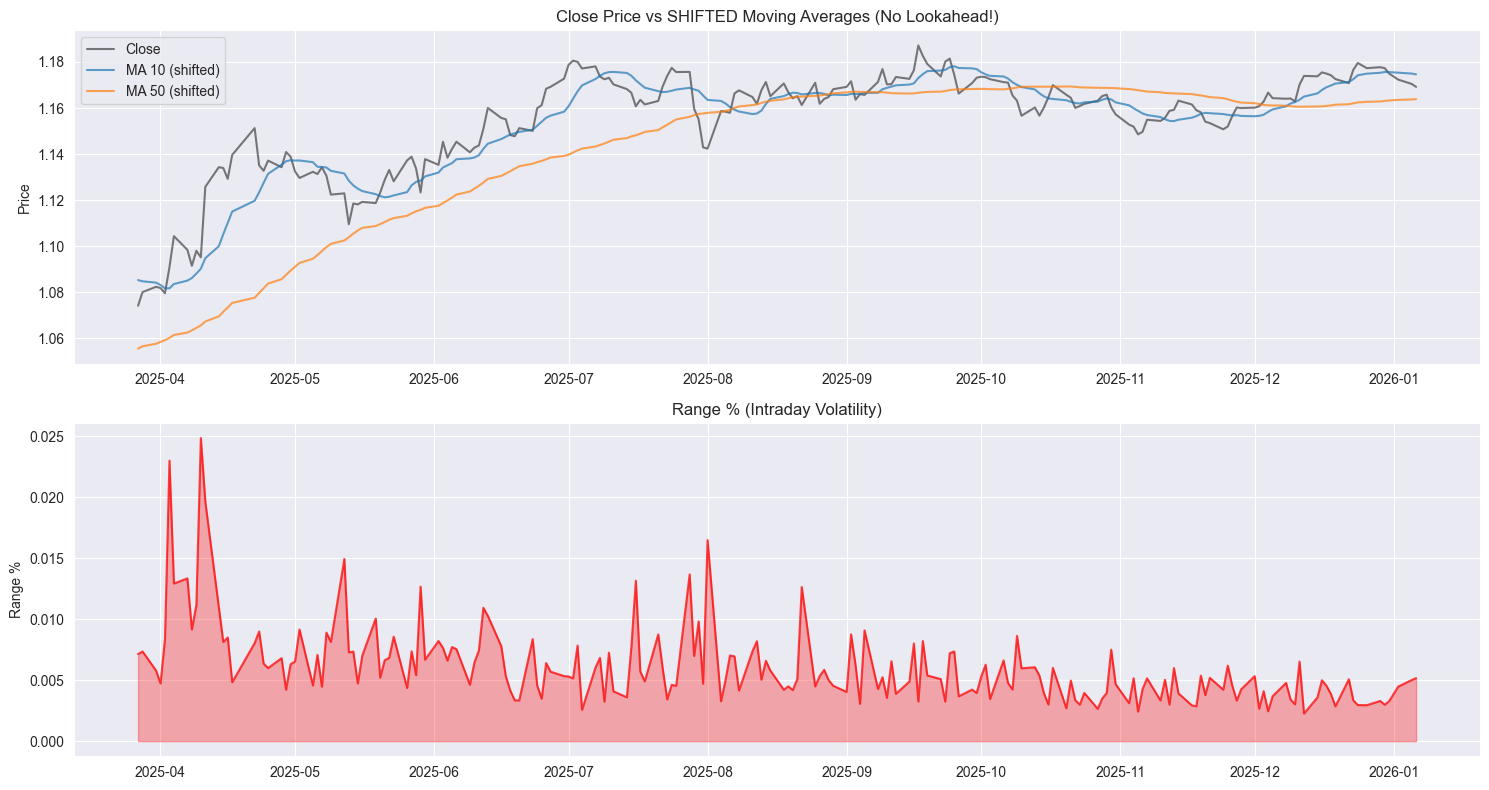

In [8]:
# Plot Moving Averages (check shifting worked)
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(df.index[-200:], df['Close'].iloc[-200:], label='Close', color='black', alpha=0.5)
plt.plot(df.index[-200:], df['MA_10'].iloc[-200:], label='MA 10 (shifted)', alpha=0.7)
plt.plot(df.index[-200:], df['MA_50'].iloc[-200:], label='MA 50 (shifted)', alpha=0.7)
plt.title("Close Price vs SHIFTED Moving Averages (No Lookahead!)")
plt.legend()
plt.ylabel("Price")

plt.subplot(2, 1, 2)
plt.plot(df.index[-200:], df['Range_Pct'].iloc[-200:], color='red', alpha=0.7)
plt.fill_between(df.index[-200:], 0, df['Range_Pct'].iloc[-200:], alpha=0.3, color='red')
plt.title("Range % (Intraday Volatility)")
plt.ylabel("Range %")

plt.tight_layout()
plt.show()


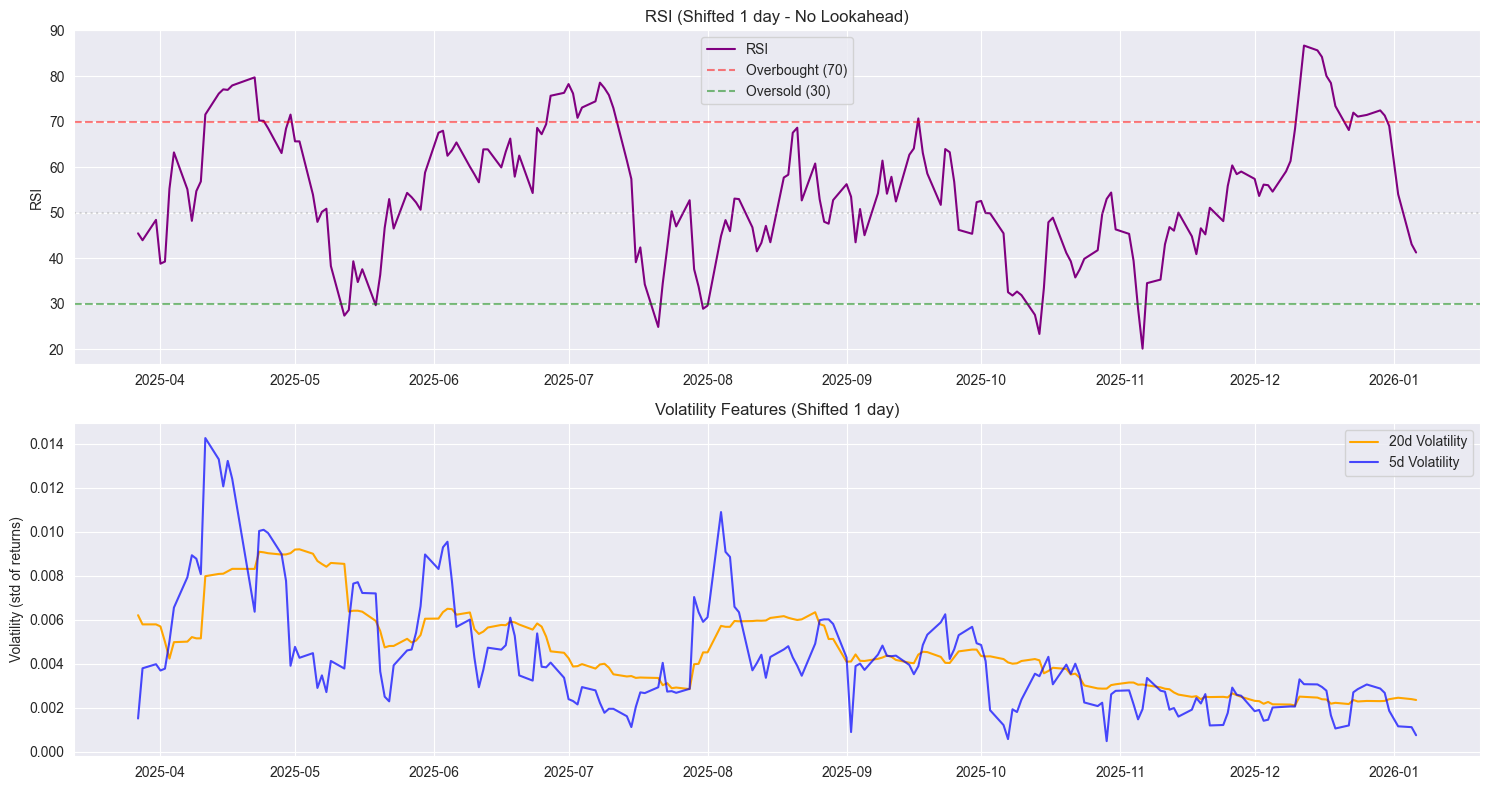

In [9]:
# Plot RSI and Volatility
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(df.index[-200:], df['RSI_14'].iloc[-200:], color='purple', label='RSI')
plt.axhline(70, linestyle='--', color='red', alpha=0.5, label='Overbought (70)')
plt.axhline(30, linestyle='--', color='green', alpha=0.5, label='Oversold (30)')
plt.axhline(50, linestyle=':', color='gray', alpha=0.3)
plt.title("RSI (Shifted 1 day - No Lookahead)")
plt.legend()
plt.ylabel("RSI")

plt.subplot(2, 1, 2)
plt.plot(df.index[-200:], df['Volatility_20d'].iloc[-200:], color='orange', label='20d Volatility')
plt.plot(df.index[-200:], df['Volatility_5d'].iloc[-200:], color='blue', label='5d Volatility', alpha=0.7)
plt.title("Volatility Features (Shifted 1 day)")
plt.legend()
plt.ylabel("Volatility (std of returns)")

plt.tight_layout()
plt.show()


## 4. Correlation Analysis & Feature Reduction

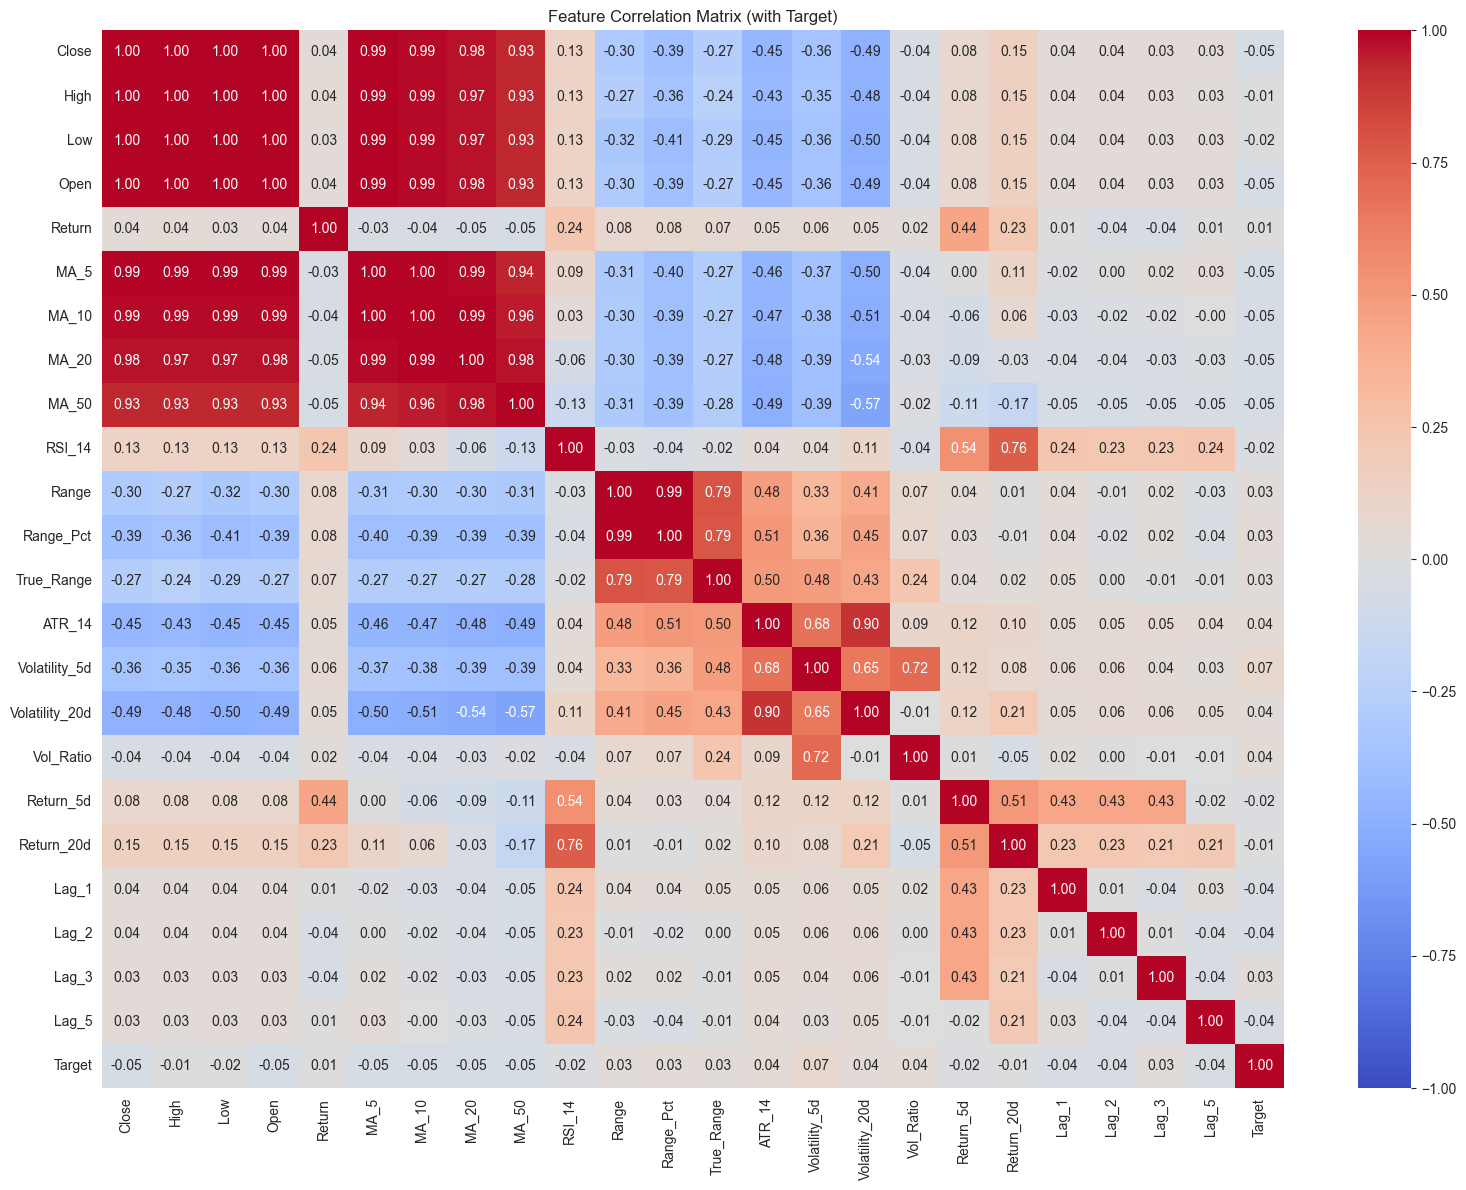


Top 10 features correlated with Target (absolute value):
  Volatility_5d       :  0.0724
  Close               : -0.0531
  Open                : -0.0531
  MA_50               : -0.0520
  MA_5                : -0.0505
  MA_10               : -0.0489
  MA_20               : -0.0482
  Lag_5               : -0.0447
  Vol_Ratio           :  0.0446
  Lag_2               : -0.0434


In [10]:
# Create target for correlation analysis
df['Target'] = df['Return'].shift(-1)

# Prepare DataFrame for correlation
corr_df = df.dropna().copy()

# Identify feature columns (exclude target and unscaled columns)
exclude_cols = ['Target', 'Return_Unscaled', 'Close_Unscaled']
feature_cols = [col for col in corr_df.columns if col not in exclude_cols]

# Calculate correlation matrix
corr_matrix = corr_df[feature_cols + ['Target']].corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, center=0)
plt.title("Feature Correlation Matrix (with Target)")
plt.tight_layout()
plt.show()

# Print correlations with target
target_corr = corr_matrix['Target'].sort_values(key=abs, ascending=False)
print("\nTop 10 features correlated with Target (absolute value):")
for idx, value in target_corr.iloc[1:11].items():  # Skip Target itself
    print(f"  {idx:20}: {value:7.4f}")


### SMART FEATURE SELECTION

In [11]:
# ================================
# SMART FEATURE SELECTION
# ================================

print("\n" + "="*60)
print("SMART FEATURE SELECTION")
print("="*60)

# Create temporary dataframe with Target for correlation analysis
temp_df = df.copy()
temp_df['Target_NextReturn'] = temp_df['Return'].shift(-1)
temp_df = temp_df.dropna()

print(f"Data for feature selection: {len(temp_df)} rows")

# Define MUST-KEEP features (from your previous analysis)
must_keep_features = ['Return', 'MA_50', 'Return_20d', 'Lag_2', 'Lag_3', 'Open', 'High', 'Low', 'Close']
print(f"\n🔒 Must-keep features (from previous analysis):")
for feat in must_keep_features:
    if feat in temp_df.columns:
        print(f"  ✓ {feat}")

# Get all features except target and metadata
exclude_from_selection = ['Target', 'Return_Unscaled', 'Close_Unscaled', 'Target_NextReturn']
all_features = [col for col in temp_df.columns if col not in exclude_from_selection]

print(f"\n📊 Total features available: {len(all_features)}")
print("All available features:")
for i, feat in enumerate(sorted(all_features), 1):
    print(f"  {i:2}. {feat}")

# Calculate correlation with target
target_corr = temp_df[all_features + ['Target_NextReturn']].corr()['Target_NextReturn'].abs()

print(f"\n📈 Feature correlation with target:")
for feat in sorted(all_features):
    corr = target_corr.get(feat, 0)
    significance = "✓" if abs(corr) > 0.03 else "⚠️"
    print(f"  {significance} {feat:20}: {corr:.4f}")

# Strategy 1: Keep must-keep features regardless of correlation
features_to_keep = [f for f in must_keep_features if f in all_features]
print(f"\n✅ Initially keeping {len(features_to_keep)} must-keep features")

# Strategy 2: Add any feature with decent correlation (> 0.03)
decent_corr_features = target_corr[target_corr > 0.03].index.tolist()
decent_corr_features = [f for f in decent_corr_features if f != 'Target_NextReturn']

new_features = [f for f in decent_corr_features if f not in features_to_keep]
if new_features:
    print(f"\n➕ Adding {len(new_features)} features with corr > 0.03:")
    for feat in new_features:
        corr = target_corr.get(feat, 0)
        print(f"  + {feat:20}: {corr:.4f}")
    features_to_keep.extend(new_features)

# Remove duplicates
features_to_keep = list(set(features_to_keep))

print(f"\n📊 After correlation filter: {len(features_to_keep)} features")

# Strategy 3: Remove highly correlated features (> 0.95) that add no value
print(f"\n🔍 Checking for redundant features (correlation > 0.95)...")

# Calculate correlation matrix only for selected features
corr_matrix = temp_df[features_to_keep].corr().abs()

to_drop = []
threshold = 0.95

# Track all potential drops for debugging
potential_drops = []

for i in range(len(features_to_keep)):
    for j in range(i + 1, len(features_to_keep)):
        feat_i = features_to_keep[i]
        feat_j = features_to_keep[j]
        
        # Skip if either is in must-keep
        if feat_i in must_keep_features and feat_j in must_keep_features:
            continue
            
        corr_value = corr_matrix.loc[feat_i, feat_j]
        
        if corr_value > threshold:
            # Check which one has lower correlation with target
            corr_i = target_corr.get(feat_i, 0)
            corr_j = target_corr.get(feat_j, 0)
            
            # Keep the one with higher target correlation
            if corr_i < corr_j:
                if feat_i not in must_keep_features:
                    potential_drops.append((feat_i, feat_j, corr_value, corr_i, corr_j))
            else:
                if feat_j not in must_keep_features:
                    potential_drops.append((feat_j, feat_i, corr_value, corr_j, corr_i))

# Sort by correlation value (highest first)
potential_drops.sort(key=lambda x: x[2], reverse=True)

# Apply drops, avoiding chain reactions
dropped_features = []
for feat_to_drop, feat_to_keep, corr_value, corr_drop, corr_keep in potential_drops:
    if feat_to_drop not in dropped_features and feat_to_drop in features_to_keep:
        to_drop.append(feat_to_drop)
        dropped_features.append(feat_to_drop)
        print(f"  🗑️ Dropping {feat_to_drop:15} (kept: {feat_to_keep:15})")
        print(f"      Correlation: {corr_value:.3f}, Target corr: {corr_drop:.3f} vs {corr_keep:.3f}")

# Apply drops
if to_drop:
    to_drop = list(set(to_drop))
    features_to_keep = [f for f in features_to_keep if f not in to_drop]
    print(f"\n🧹 Removed {len(to_drop)} redundant features")
else:
    print(f"\n✅ No redundant features found")

# Final feature set
print(f"\n🎯 FINAL FEATURE SET ({len(features_to_keep)} features):")
for i, feat in enumerate(sorted(features_to_keep), 1):
    corr = target_corr.get(feat, 0)
    print(f"  {i:2}. {feat:20} (target corr: {corr:.4f})")

# Now drop unselected features from main dataframe
all_possible_features = [col for col in df.columns if col not in exclude_from_selection]
features_to_drop_from_df = [f for f in all_possible_features if f not in features_to_keep]

if features_to_drop_from_df:
    print(f"\n🗑️  Dropping {len(features_to_drop_from_df)} unselected features from dataframe:")
    for feat in sorted(features_to_drop_from_df):
        corr = target_corr.get(feat, 0)
        print(f"  - {feat:20} (target corr: {corr:.4f})")
    
    df = df.drop(columns=features_to_drop_from_df)

# Clean up temp columns
if 'Target_NextReturn' in df.columns:
    df = df.drop(columns=['Target_NextReturn'])

print(f"\n✅ Feature selection complete!")
print(f"   Final dataframe shape: {df.shape}")
features_list = [col for col in df.columns if col not in ['Target', 'Return_Unscaled', 'Close_Unscaled']]
print(f"   Features ({len(features_list)}): {features_list}")


SMART FEATURE SELECTION
Data for feature selection: 1257 rows

🔒 Must-keep features (from previous analysis):
  ✓ Return
  ✓ MA_50
  ✓ Return_20d
  ✓ Lag_2
  ✓ Lag_3
  ✓ Open
  ✓ High
  ✓ Low
  ✓ Close

📊 Total features available: 23
All available features:
   1. ATR_14
   2. Close
   3. High
   4. Lag_1
   5. Lag_2
   6. Lag_3
   7. Lag_5
   8. Low
   9. MA_10
  10. MA_20
  11. MA_5
  12. MA_50
  13. Open
  14. RSI_14
  15. Range
  16. Range_Pct
  17. Return
  18. Return_20d
  19. Return_5d
  20. True_Range
  21. Vol_Ratio
  22. Volatility_20d
  23. Volatility_5d

📈 Feature correlation with target:
  ✓ ATR_14              : 0.0432
  ✓ Close               : 0.0531
  ⚠️ High                : 0.0142
  ✓ Lag_1               : 0.0357
  ✓ Lag_2               : 0.0434
  ⚠️ Lag_3               : 0.0257
  ✓ Lag_5               : 0.0447
  ⚠️ Low                 : 0.0155
  ✓ MA_10               : 0.0489
  ✓ MA_20               : 0.0482
  ✓ MA_5                : 0.0505
  ✓ MA_50               : 

In [12]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Return', 'MA_50', 'Range_Pct',
       'ATR_14', 'Volatility_5d', 'Volatility_20d', 'Vol_Ratio', 'Return_20d',
       'Lag_1', 'Lag_2', 'Lag_3', 'Lag_5', 'Target', 'Return_Unscaled',
       'Close_Unscaled'],
      dtype='object')

In [13]:
# # Remove highly correlated features (> 0.95)
# threshold = 0.95
# cols_to_drop = set()

# # Check feature-feature correlations
# for i in range(len(feature_cols)):
#     for j in range(i + 1, len(feature_cols)):
#         col1 = feature_cols[i]
#         col2 = feature_cols[j]
#         corr_value = abs(corr_matrix.loc[col1, col2])
        
#         if corr_value > threshold:
#             # Keep the one more correlated with target
#             corr1_target = abs(corr_matrix.loc[col1, 'Target'])
#             corr2_target = abs(corr_matrix.loc[col2, 'Target'])
            
#             if corr1_target < corr2_target:
#                 cols_to_drop.add(col1)
#                 print(f"Dropping {col1} (corr with {col2}: {corr_value:.3f}, target corr: {corr1_target:.3f} vs {corr2_target:.3f})")
#             else:
#                 cols_to_drop.add(col2)
#                 print(f"Dropping {col2} (corr with {col1}: {corr_value:.3f}, target corr: {corr2_target:.3f} vs {corr1_target:.3f})")

# # Drop highly correlated features
# if cols_to_drop:
#     df = df.drop(columns=list(cols_to_drop))
#     print(f"\nDropped {len(cols_to_drop)} highly correlated features.")
# else:
#     print("\nNo features with correlation > 0.95 found.")

# print(f"\nRemaining features: {len([c for c in df.columns if c not in ['Target', 'Return_Unscaled', 'Close_Unscaled']])}")


### Correlation Heatmap (Cleaned)

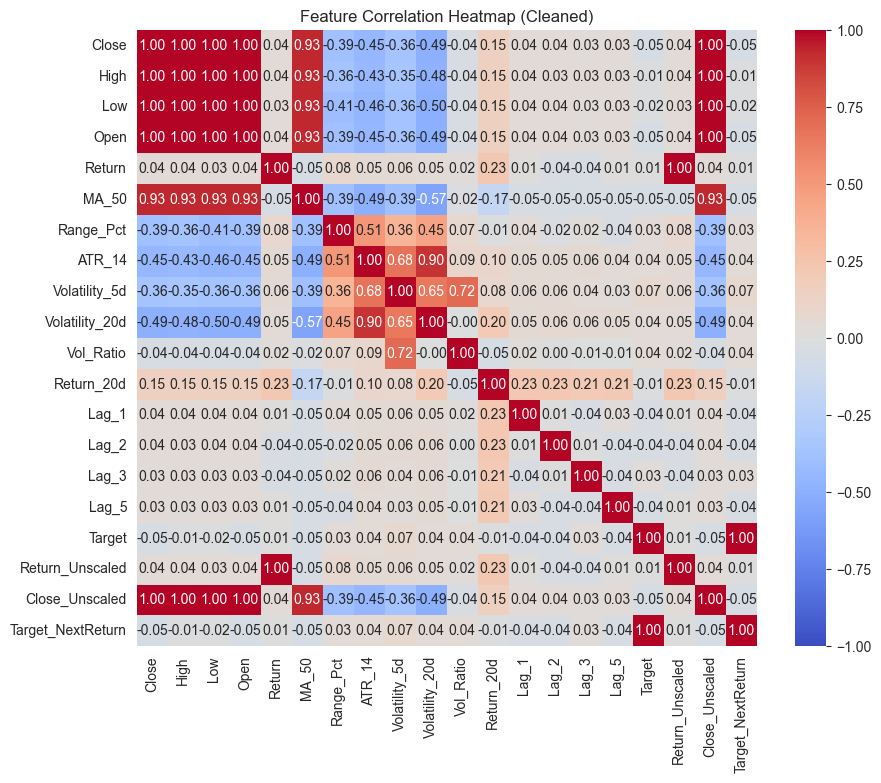

In [14]:
# Correlation Heatmap (Cleaned)

plt.figure(figsize=(10, 8))
# Re-calc Target for Viz
df['Target_NextReturn'] = df['Return'].shift(-1)
# features now are whatever is left in df (excluding basics)
final_cols = [c for c in df.columns if c not in ['Target_NextReturn']]

corr_final = df[final_cols + ['Target_NextReturn']].corr()
sns.heatmap(corr_final, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap (Cleaned)")
plt.show()

df = df.drop(columns=['Target_NextReturn'])


## 5. Train/Test Split with FIXED DATE

In [ ]:
# IMPORTANT: Use FIXED date for reproducible splits
# Train: 2020-12-28 to 2024-12-31
# Test:  2025-01-01 onwards

test_start_date = pd.Timestamp('2025-01-01')

if df.index.max() < test_start_date:
    print(f"WARNING: Data ends at {df.index.max().date()}, can't split at {test_start_date.date()}")
    print("Using 80/20 split instead.")
    train_size = int(len(df) * 0.8)
    train_df = df.iloc[:train_size].copy()
    test_df = df.iloc[train_size:].copy()
else:
    train_df = df[df.index < test_start_date].copy()
    test_df = df[df.index >= test_start_date].copy()

print(f"\nTrain set: {len(train_df)} rows ({train_df.index.min().date()} to {train_df.index.max().date()})")
print(f"Test set:  {len(test_df)} rows ({test_df.index.min().date()} to {test_df.index.max().date()})")

# Verify no overlap
overlap = train_df.index.intersection(test_df.index)
if len(overlap) > 0:
    print(f"\n⚠️  WARNING: Overlap found! {len(overlap)} overlapping dates.")
else:
    print("\n✅ No overlap between train and test sets.")



Train set: 998 rows (2021-03-05 to 2024-12-31)
Test set:  260 rows (2025-01-02 to 2026-01-06)

✅ No overlap between train and test sets.


## 6. Remove Last Row from Test (Target NaN fix)

In [17]:
# Check and fix last row NaN issue in test set
last_row_has_nan = test_df.iloc[-1].isna().any()
if last_row_has_nan:
    print(f"⚠️ Last row of test set ({test_df.index[-1].date()}) has NaN")
    print("  This is because Target = Return.shift(-1) for last date")
    print("  Removing last row from test set...")
    
    test_df = test_df.iloc[:-1]  # Remove last row
    print(f"  New test size: {len(test_df)} rows")

# Final NaN check
train_nan = train_df.isna().sum().sum()
test_nan = test_df.isna().sum().sum()

if train_nan > 0 or test_nan > 0:
    print(f"\n❌ ERROR: NaN values still present!")
    print(f"  Train NaN: {train_nan}")
    print(f"  Test NaN:  {test_nan}")
    
    # Show which columns have NaN
    for df_name, df_data in [('Train', train_df), ('Test', test_df)]:
        nan_cols = df_data.columns[df_data.isna().any()].tolist()
        if nan_cols:
            print(f"  {df_name} NaN columns: {nan_cols}")
    
    # Emergency cleanup
    print("\n🧹 Performing emergency cleanup...")
    train_df = train_df.dropna()
    test_df = test_df.dropna()
    print(f"  New train size: {len(train_df)} rows")
    print(f"  New test size:  {len(test_df)} rows")
else:
    print("\n✅ Both train and test sets are clean (no NaN)!")

print(f"\n📊 Final dataset sizes:")
print(f"  Train: {len(train_df)} rows ({train_df.index.min().date()} to {train_df.index.max().date()})")
print(f"  Test:  {len(test_df)} rows ({test_df.index.min().date()} to {test_df.index.max().date()})")

# Verify no overlap
overlap = train_df.index.intersection(test_df.index)
if len(overlap) > 0:
    print(f"\n⚠️ WARNING: Overlap found! {len(overlap)} overlapping dates:")
    for date in overlap[:5]:
        print(f"  - {date.date()}")
else:
    print("\n✅ No overlap between train and test sets.")

⚠️ Last row of test set (2026-01-06) has NaN
  This is because Target = Return.shift(-1) for last date
  Removing last row from test set...
  New test size: 259 rows

✅ Both train and test sets are clean (no NaN)!

📊 Final dataset sizes:
  Train: 998 rows (2021-03-05 to 2024-12-31)
  Test:  259 rows (2025-01-02 to 2026-01-05)

✅ No overlap between train and test sets.


## CRITICAL: DATA LEAKAGE CHECK

In [18]:
# ================================
# CRITICAL: DATA LEAKAGE CHECK
# ================================

print("\n" + "="*60)
print("DATA LEAKAGE AUDIT")
print("="*60)

print("\n🔍 1. Checking Target Definition...")
print("Sample timeline (first 5 train rows):")
for i in range(min(5, len(train_df))):
    date = train_df.index[i]
    return_t = train_df.iloc[i]['Return']
    target_t = train_df.iloc[i]['Target']
    print(f"  {date.date()}: Return={return_t:.6f}, Target={target_t:.6f} (should be tomorrow's return)")

print("\n🔍 2. Checking Feature Availability...")
# Check if any feature uses future data
problematic_features = []
for col in train_df.columns:
    if col not in ['Target', 'Return_Unscaled', 'Close_Unscaled']:
        # Check correlation with target - if too high, suspicious
        corr = train_df[col].corr(train_df['Target'])
        if abs(corr) > 0.7:  # Suspiciously high
            problematic_features.append((col, corr))

if problematic_features:
    print("⚠️  Suspiciously high feature-target correlations:")
    for feat, corr in problematic_features:
        print(f"  - {feat}: {corr:.4f}")
else:
    print("✅ Feature-target correlations look normal")

print("\n🔍 3. Checking Train/Test Contamination...")
# Ensure no date overlap
overlap = train_df.index.intersection(test_df.index)
if len(overlap) > 0:
    print(f"❌ FOUND OVERLAP! {len(overlap)} dates in both train and test")
    for date in overlap[:3]:
        print(f"  - {date.date()}")
else:
    print("✅ No overlap between train and test sets")

print("\n🔍 4. Baseline Performance Check...")
# What's the naive baseline?
naive_pred = test_df['Return'].values  # Predict today = tomorrow
actual_returns = test_df['Target'].values
naive_da = (np.sign(naive_pred) == np.sign(actual_returns)).mean()

print(f"  Naive baseline (predict today=tomorrow): {naive_da:.2%}")
print(f"  Expected realistic DA: 52-60%")
print(f"  Warning if >65%: Possible leakage")

print("\n✅ Data leakage audit complete")


DATA LEAKAGE AUDIT

🔍 1. Checking Target Definition...
Sample timeline (first 5 train rows):
  2021-03-05: Return=-0.006881, Target=-0.003518 (should be tomorrow's return)
  2021-03-08: Return=-0.003518, Target=-0.006198 (should be tomorrow's return)
  2021-03-09: Return=-0.006198, Target=0.003898 (should be tomorrow's return)
  2021-03-10: Return=0.003898, Target=0.002366 (should be tomorrow's return)
  2021-03-11: Return=0.002366, Target=0.005034 (should be tomorrow's return)

🔍 2. Checking Feature Availability...
✅ Feature-target correlations look normal

🔍 3. Checking Train/Test Contamination...
✅ No overlap between train and test sets

🔍 4. Baseline Performance Check...
  Naive baseline (predict today=tomorrow): 51.35%
  Expected realistic DA: 52-60%
  Warning if >65%: Possible leakage

✅ Data leakage audit complete


## 7. Scaling (Target NOT Scaled!)

In [19]:
# Define columns to scale (exclude Target and unscaled columns)
exclude_from_scaling = ['Target', 'Return_Unscaled', 'Close_Unscaled']
cols_to_scale = [col for col in train_df.columns if col not in exclude_from_scaling]

print(f"Scaling {len(cols_to_scale)} features:")
# for col in cols_to_scale[:10]:  # Show first 10
#     print(f"  - {col}")
# if len(cols_to_scale) > 10:
#     print(f"  ... and {len(cols_to_scale) - 10} more")
for col in cols_to_scale:  # Show all
    print(f"  - {col}")

# Initialize and fit scaler
scaler = MinMaxScaler()

# Scale features
train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

train_df_scaled[cols_to_scale] = scaler.fit_transform(train_df[cols_to_scale])
test_df_scaled[cols_to_scale] = scaler.transform(test_df[cols_to_scale])

# IMPORTANT: Target remains unscaled! We'll predict raw returns.
# This makes interpretation easier and allows direct comparison with ARIMA
print("\n✅ Scaling complete. Target column remains unscaled.")
print(f"Target mean in train: {train_df_scaled['Target'].mean():.6f}")
print(f"Target mean in test:  {test_df_scaled['Target'].mean():.6f}")


# After scaling:
print("\n🔍 Final NaN check after scaling:")
print(f"  Train scaled NaN: {train_df[cols_to_scale].isna().sum().sum()}")
print(f"  Test scaled NaN:  {test_df[cols_to_scale].isna().sum().sum()}")

if train_df[cols_to_scale].isna().sum().sum() > 0 or test_df[cols_to_scale].isna().sum().sum() > 0:
    print("\n⚠️ WARNING: NaN found after scaling!")
    # Fill with 0 or median
    for df_data in [train_df, test_df]:
        df_data[cols_to_scale] = df_data[cols_to_scale].fillna(0)
    print("  NaN filled with 0")

Scaling 16 features:
  - Close
  - High
  - Low
  - Open
  - Return
  - MA_50
  - Range_Pct
  - ATR_14
  - Volatility_5d
  - Volatility_20d
  - Vol_Ratio
  - Return_20d
  - Lag_1
  - Lag_2
  - Lag_3
  - Lag_5

✅ Scaling complete. Target column remains unscaled.
Target mean in train: -0.000134
Target mean in test:  0.000483

🔍 Final NaN check after scaling:
  Train scaled NaN: 0
  Test scaled NaN:  0


## 8. Save Processed Data

In [20]:
# Save using DataManager
dm_processed = DataManager(data_type='processed', local_dir=os.path.join(root_path, 'data/processed'))

metadata = {
    'version': 'v2_fixed_leakage',
    'train_start': train_df.index.min().strftime('%Y-%m-%d'),
    'train_end': train_df.index.max().strftime('%Y-%m-%d'),
    'test_start': test_df.index.min().strftime('%Y-%m-%d'),
    'test_end': test_df.index.max().strftime('%Y-%m-%d'),
    'features_scaled': cols_to_scale,
    'features_unscaled': ['Target', 'Return_Unscaled', 'Close_Unscaled'],
    'notes': 'Fixed data leakage with shift(1), added range/RSI/vol features'
}

success = dm_processed.save_processed(
    train_df=train_df_scaled,
    test_df=test_df_scaled,
    scaler=scaler,
    metadata=metadata
)

if success:
    print("✅ Processed data saved successfully!")
    print(f"\nMetadata:")
    for key, value in metadata.items():
        if key != 'features_scaled':
            print(f"  {key}: {value}")
    print(f"  features_scaled: {len(metadata['features_scaled'])} features")
else:
    print("❌ Failed to save processed data.")


✅ Processed data saved successfully!

Metadata:
  version: v2_fixed_leakage
  train_start: 2021-03-05
  train_end: 2024-12-31
  test_start: 2025-01-02
  test_end: 2026-01-05
  features_unscaled: ['Target', 'Return_Unscaled', 'Close_Unscaled']
  notes: Fixed data leakage with shift(1), added range/RSI/vol features
  features_scaled: 16 features


## 9. Final Visualization

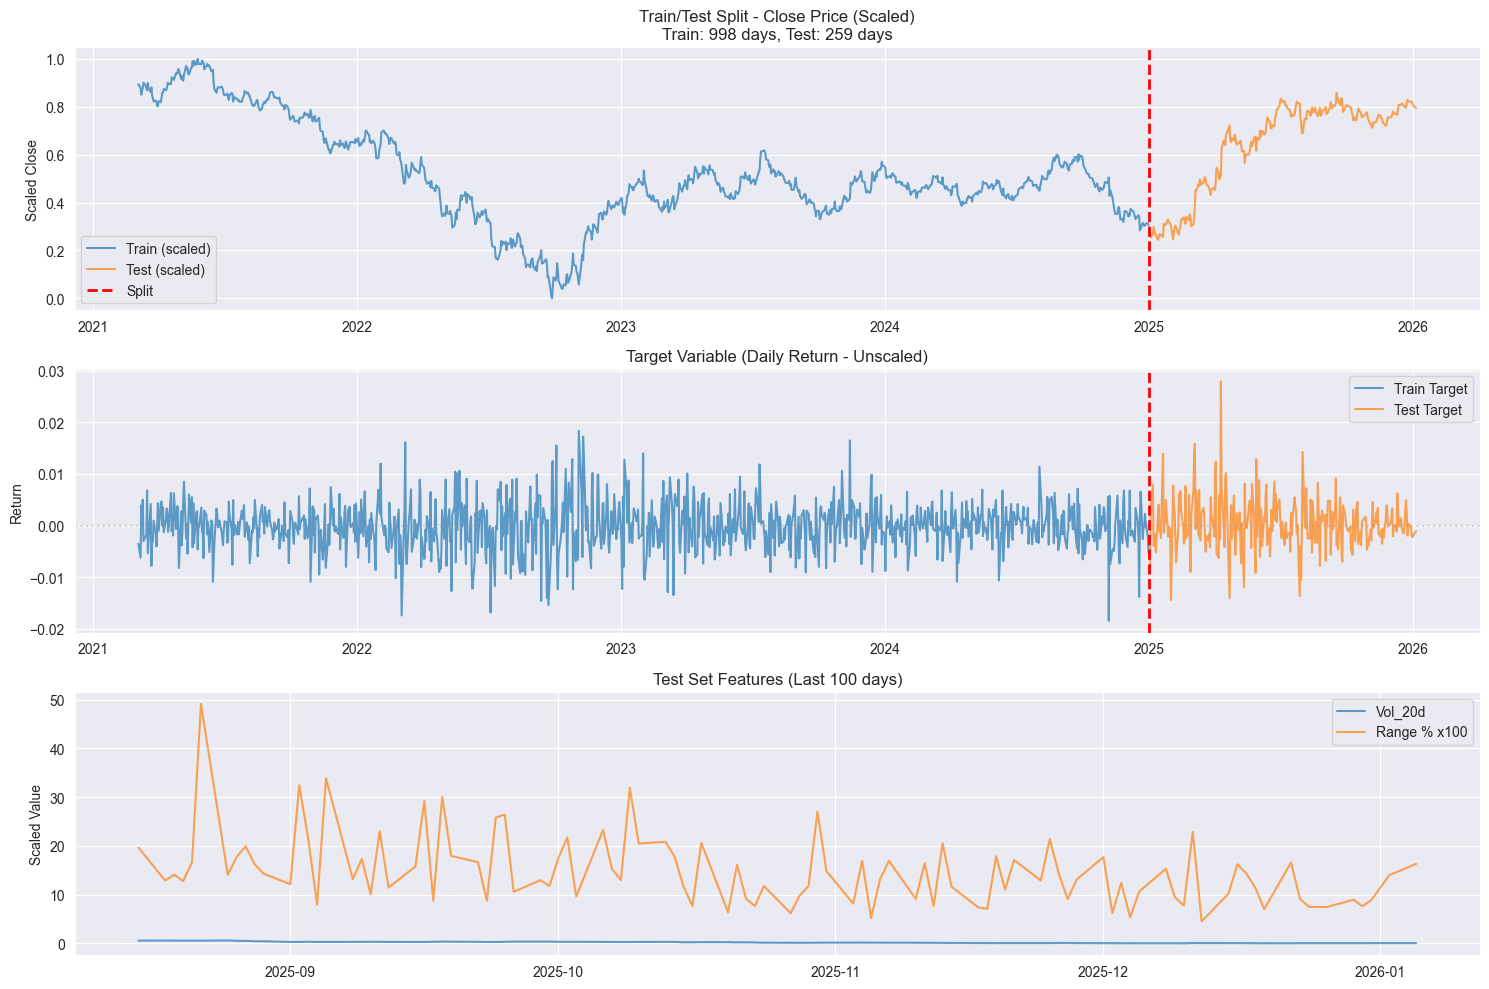


🎯 PREPROCESSING COMPLETE!
Next: Run 03_train_models.ipynb to train models with fixed split.


In [21]:
# Plot train/test split
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(train_df_scaled.index, train_df_scaled['Close'], label='Train (scaled)', alpha=0.7)
plt.plot(test_df_scaled.index, test_df_scaled['Close'], label='Test (scaled)', alpha=0.7)
plt.axvline(test_start_date, color='red', linestyle='--', linewidth=2, label='Split')
plt.title(f"Train/Test Split - Close Price (Scaled)\nTrain: {len(train_df_scaled)} days, Test: {len(test_df_scaled)} days")
plt.legend()
plt.ylabel("Scaled Close")

plt.subplot(3, 1, 2)
plt.plot(train_df_scaled.index, train_df_scaled['Target'], label='Train Target', alpha=0.7)
plt.plot(test_df_scaled.index, test_df_scaled['Target'], label='Test Target', alpha=0.7)
plt.axvline(test_start_date, color='red', linestyle='--', linewidth=2)
plt.axhline(0, color='gray', linestyle=':', alpha=0.3)
plt.title("Target Variable (Daily Return - Unscaled)")
plt.legend()
plt.ylabel("Return")

plt.subplot(3, 1, 3)
# Plot last 100 days of key features
sample_idx = test_df_scaled.index[-100:]
# plt.plot(sample_idx, test_df_scaled.loc[sample_idx, 'RSI_14'], label='RSI_14', alpha=0.7)
plt.plot(sample_idx, test_df_scaled.loc[sample_idx, 'Volatility_20d'], label='Vol_20d', alpha=0.7)
plt.plot(sample_idx, test_df_scaled.loc[sample_idx, 'Range_Pct'] * 100, label='Range % x100', alpha=0.7)
plt.title("Test Set Features (Last 100 days)")
plt.legend()
plt.ylabel("Scaled Value")

plt.tight_layout()
plt.show()

print("\n🎯 PREPROCESSING COMPLETE!")
print("Next: Run 03_train_models.ipynb to train models with fixed split.")
